In [2]:
using Distributions;
using Images;

---

In [3]:
const dt::Float64 = 0.1
const N_trials::Int = 4000
const T::Int = 100;

In [4]:
const N_out::Int = 10
const N_latent::Int = 40

const N::Int = N_out + N_latent;

In [5]:
const M::Float64 = 1.25
const θ::Float64 = 0.15;
const E_exc::Float64 = 1
const E_inh::Float64 = -1
const gl::Float64 = 0.1
const g_den::Float64 = 2.0
const g_0::Float64 = 0.3
const a::Float64 = 21
const b::Float64 = 0.18
const delta::Float64 = 25.

rho(u) = 1. / (1. + exp(a*(b-u)))

d_den::Vector{Float64} = round.(rand(Uniform(5., 15.), N), digits=1)
d_som_exc::Vector{Float64} = round.(rand(Uniform(5., 15.), N), digits=1)
d_som_inh::Vector{Float64} = d_som_exc .+ delta;

In [6]:
const ηl::Float64 = 0.0001
const λ::Float64 = 0.6
W_init = Normal(0., 0.05)

Normal{Float64}(μ=0.0, σ=0.05)

---

In [7]:
const B::Matrix{Float64} = g_0*Float64.(rand(N_latent, N) .< 2/N);

---

In [8]:
function create_queues!(ds::Vector{Float64})::Vector{Vector{Float64}}
    qs = [Vector{Float64}() for _ in 1:N]
    initialize!((q,d)) = (x->push!(q,x)).(rho.(zeros(Int(d ÷ dt))))
    initialize!.(zip(qs, ds))
    return qs
end;

---

In [9]:
function memory!(r::Vector{Float64})
    for (q_den, q_exc, q_inh, x) in zip(m_den, m_som_exc, m_som_inh, r)
        push!(q_den, x)
        push!(q_exc, x)
        push!(q_inh, x)
    end
end;

In [10]:
function step!(u::Vector{Float64},u_tgt::Vector{Float64},v::Vector{Float64},rbar::Vector{Float64},W::Matrix{Float64};teacher::Bool=true)
    past_den_r = popfirst!.(m_den)
    I_den = W * past_den_r
    g_exc = B * popfirst!.(m_som_exc)
    g_inh = B * popfirst!.(m_som_inh)
    effective_alpha_t::Float64 = teacher ? (λ/(1-λ)) * (gl+g_den) : 0.
    for i in 1:N_out
        @inbounds u[i] += dt* (-(gl+g_den)*u[i] + g_den * v[i] + effective_alpha_t *(u_tgt[i] - u[i]) )
    end
    for i in N_out+1:N
        @inbounds u[i] += dt* (-(gl+g_den)*u[i] + g_den * v[i] + g_exc[i-N_out] * (1. - u[i]) + g_inh[i-N_out] * (-1. - u[i]))
    end
    for i in 1:N
        @inbounds v[i] += dt*(-gl*v[i] + I_den[i])
        @inbounds rbar[i] += dt*(-gl*rbar[i] + ((gl*g_den)/(gl+g_den))*past_den_r[i])
    end
    r = rho.(u)
    vstar = rho.((g_den/(gl+g_den))*v)
    memory!(r)
    for i in 1:N, j in 1:N
        @inbounds W[i,j] += dt * ηl *(r[i]-vstar[i])*rbar[j]
    end
    return nothing;
end;

On my way to simplification:

$$\dot{v} = -g_l v + W\rho(u_{t-\tau_d})$$
$$\dot{u} = -g_l u + g_{d} (v-u) + \mathbb{1}_{lat}\left[g_eB \rho(u_{t-\tau_e}) \odot (1-u) + g_iB \rho(u_{t-\tau_e-\delta}) \odot (-1-u)\right] +\mathbb{1}_{out}\left[\frac{\lambda(g_l+g_{d})}{1-\lambda}(u_{tgt}-u)\right]$$
$$\dot{\bar{r}} = -g_l\bar{r} + \frac{g_lg_{d}}{g_l+g_{d}} \rho(u_{t-\tau_d})$$
$$\dot{W} = \eta\left[\rho(u)-\rho\left(\frac{g_{d}}{g_l+g_{d}} v\right)\right]\bar{r}^T$$

---

In [10]:
function train!(u::Vector{Float64}, v::Vector{Float64}, rbar::Vector{Float64}, W::Matrix{Float64}, target::Function, T::Int, n_trials::Int; test_every::Int=1000, θ::Float64=-60., dt::Float64=0.1)
    for trial in 0:n_trials-1
        for t in 0:dt:T-dt
            step!(u, target(t), v, rbar, W, teacher=true)
        end
        (trial % test_every == 0) && test!(u, v, rbar, W, T, dt=dt, θ=θ)
    end
end

train! (generic function with 1 method)

In [11]:
function test!(u::Vector{Float64}, v::Vector{Float64}, rbar::Vector{Float64}, W::Matrix{Float64}, T::Int; dt::Float64=0.1, θ::Float64=-60)
    u_prod = Vector{Vector{Float64}}()
    for t in 0:dt:T-dt
        step!(u, zeros(N_out), v, rbar, W, teacher=false)
        isinteger(t) && push!(u_prod, u[1:N_out])
    end
    check(vv) = reduce(hcat, vv) .> θ
    display(colors[1 .+ 2*check(u_prod) + check([target(t) for t in 0:T-1])])
end
colors = [colorant"white", colorant"red", colorant"cyan", colorant"black"];

---

In [12]:
v::Vector{Float64} = zeros(N)
u::Vector{Float64} = zeros(N)
rbar::Vector{Float64} = rho.(u);
W::Matrix{Float64} = rand(W_init, N, N);

In [13]:
m_den::Vector{Vector{Float64}} = create_queues!(d_den)
m_som_exc::Vector{Vector{Float64}} = create_queues!(d_som_exc)
m_som_inh::Vector{Vector{Float64}} = create_queues!(d_som_inh);

In [14]:
chords = [rand(N_out).>.75 for j in 1:10]
target(t) = M*Float64.(chords[Int(t÷10+1)]);
#broadcast.(Gray, (!).(mapreduce(permutedims,vcat,repeat(chords, inner=10))'))

target (generic function with 1 method)

---

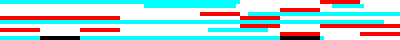

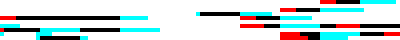

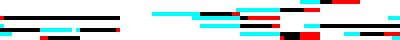

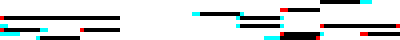

In [15]:
train!(u, v, rbar, W, target, T, N_trials, θ=θ, dt=dt)

In [15]:
using BenchmarkTools
u_tgt_bench::Vector{Float64} = M*Float64.(rand(N_out).>.75);
@benchmark step!($u, $u_tgt_bench, $v, $rbar, $W)

BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.571 μs …  1.422 ms  ┊ GC (min … max): 0.00% … 99.24%
 Time  (median):     3.764 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.444 μs ± 18.725 μs  ┊ GC (mean ± σ):  6.81% ±  1.71%

  ▃▇▇██▆▅▃▂▁                   ▂▂▂▁▂▃▃▃▂▃▃▂▂▁▁               ▂
  ██████████████▇█▇█▆▆▆▄▄▆▃▅▄▂▆██████████████████▇▇▆▆▇▆▆▆▅▅▆ █
  3.57 μs      Histogram: log(frequency) by time     6.19 μs <

 Memory estimate: 4.06 KiB, allocs estimate: 18.